# Lasso Regression on Kaggle Wine Dataset

In [17]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt

### Loading the Dataset

In [169]:
#LOADING THE DATASET
#id, points, description
trainData1 = pd.read_csv('data/trainData.txt', delimiter = " ", names = ["iid","fid","fv"])
trainData1['iid']=trainData1['iid']-1
trainData1['fid']=trainData1['fid']-1
validationData1 = pd.read_csv("data/valData.txt", delimiter = " ", names = ["iid","fid","fv"])
validationData1['iid'] = validationData1['iid']-1
validationData1['fid'] = validationData1['fid']-1
VX = sparse.csr_matrix((validationData1['fv'], (validationData1['iid'],validationData1['fid']))) 
X = sparse.csr_matrix((trainData1['fv'], (trainData1['iid'],trainData1['fid'])))
X = X.T
Xt = X.T
VX = VX.T
d = X.shape[0]
n = X.shape[1]

In [170]:
#weight matrix
W = np.random.rand(d)
# W = np.zeros(3000)
Yload = pd.read_csv('data/trainLabels.txt', delimiter = " ", header = None)
YVload = pd.read_csv('data/valLabels.txt', delimiter = " ", header = None)
#train labels
Y = np.array(Yload).reshape(n)
YV = np.array(YVload).reshape(n)
b = np.zeros(n)

lambda_max = 2*np.linalg.norm(X.dot(Y - np.mean(Y)), ord=np.inf)
#Calculating ak
ak = 2*np.sum(i*i for i in X.T.toarray())

In [171]:
def coordinate_descent(lambda_max, Y, X, W, b):
    trainRMSE = []
    validationRMSE = []
    lambdavalues = []
    lossvalues = []
    nonzeroes = []
    
    prev_loss = float('inf')
    loss = 0
    delta = 0.1
    RMSE = 1002
    RMSEP = 1002
    
    while RMSE <= RMSEP:

        #set convergence condition
        while abs(loss-prev_loss) >= delta:
            if RMSE > RMSEP:
                break
                
            prev_loss = loss
            #STEP 1: Computing residual vector r (4.1.1)
            r = Y - X.T*W - b

            #STEP 2: Update b (4.1.2)
            bOld = b
            b = (1.0/n)*(r+b).sum()

            #STEP 3: Update r(4.1.3)
            r = r + bOld - b
            for k in range(d):
                #STEP 4: Calculate ck (4.1.4) 
                xik = X[k]

                t = xik.T*W[k]
                t = t.toarray().reshape(n)

                ck = 2*xik*(r+t)
                ck =  ck.item(0)

                #STEP 5: Update wk
                Wo = W[k]
                if ck < -lambda_max:
                    W[k] = (ck + lambda_max)/ak[k]
                elif -lambda_max <= ck <= lambda_max:
                    W[k] = 0
                elif ck > lambda_max:
                    W[k] = (ck - lambda_max)/ak[k]

                #STEP 6: Update r (4.1.5)        
                r = r.reshape(n,1) + X[k].T*(Wo-W[k])
                r = np.squeeze(np.asarray(r))
            
            
            RMSEP = RMSE
            RMSE = rmse(VX.T*W+b, YV)
            #collecting rmse validation values for graph
            validationRMSE.append(RMSE)
            
            #collecting rmse training values for graph
            trmse = rmse(X.T*W+b, Y)
            trainRMSE.append(trmse)
            
            print "RMSE, RMSEP:",RMSE,RMSEP
            #Loss

            t1 = (X.T*W+b-Y)
            t11 = np.square(t1)
            t2 = np.sum(t11)
            loss = t2 + lambda_max*(np.sum(np.absolute(W)))
            print "Loss: ",loss
            lossvalues.append(loss)
            #lambda values for graph
            lambdavalues.append(lambda_max)
            
            lambda_max = lambda_max/2
            nonzeroes.append(np.count_nonzero(W))
            
    return trainRMSE, validationRMSE, lambdavalues, lossvalues, nonzeroes, W, b
            
def rmse(P, A):
    return np.sqrt(((P-A)**2).mean())

def fit(lambda_max, Y, X, W, b):
    trainRMSE = []
    lambdavalues = []
    lossvalues = []
    nonzeroes = []
    
    prev_loss = float('inf')
    loss = 0
    delta = 0.1
    
    #set convergence condition
    while abs(loss-prev_loss) >= delta:

        prev_loss = loss
        #STEP 1: Computing residual vector r (4.1.1)
        r = Y - X.T*W - b

        #STEP 2: Update b (4.1.2)
        bOld = b
        b = (1.0/n)*(r+b).sum()

        #STEP 3: Update r(4.1.3)
        r = r + bOld - b
        for k in range(d):
            #STEP 4: Calculate ck (4.1.4) 
            xik = X[k]

            t = xik.T*W[k]
            t = t.toarray().reshape(n)

            ck = 2*xik*(r+t)
            ck =  ck.item(0)

            #STEP 5: Update wk
            Wo = W[k]
            if ck < -lambda_max:
                W[k] = (ck + lambda_max)/ak[k]
            elif -lambda_max <= ck <= lambda_max:
                W[k] = 0
            elif ck > lambda_max:
                W[k] = (ck - lambda_max)/ak[k]

            #STEP 6: Update r (4.1.5)        
            r = r.reshape(n,1) + X[k].T*(Wo-W[k])
            r = np.squeeze(np.asarray(r))


        #collecting rmse training values for graph
        trmse = rmse(X.T*W+b, Y)
        trainRMSE.append(trmse)

        #Loss
        t1 = (X.T*W+b-Y)
        t11 = np.square(t1)
        t2 = np.sum(t11)
        loss = t2 + lambda_max*(np.sum(np.absolute(W)))
        print "Loss: ",loss
        lossvalues.append(loss)
        #lambda values for graph

        nonzeroes.append(np.count_nonzero(W))

    return trainRMSE, lossvalues, nonzeroes, W, b
    
def predict(W, X, b):
    return W.T*X+b


In [172]:
# r = Y - X.T*W - b
trainRMSE, validationRMSE, lambdavalues, lossvalues, nonzeroes, W_f, b_f = coordinate_descent(lambda_max, Y, X, W, b)

RMSE, RMSEP: 3.674432595136281 1002
Loss:  156219.8447759767
RMSE, RMSEP: 3.281769756113443 3.674432595136281
Loss:  120290.43254417196
RMSE, RMSEP: 2.999308942322199 3.281769756113443
Loss:  106227.83205931788
RMSE, RMSEP: 2.7580247829868267 2.999308942322199
Loss:  93638.93135233488
RMSE, RMSEP: 2.531297191857193 2.7580247829868267
Loss:  81075.50675873258
RMSE, RMSEP: 2.3604884258078784 2.531297191857193
Loss:  69188.0040797508
RMSE, RMSEP: 2.2285187942171194 2.3604884258078784
Loss:  59096.85793208121
RMSE, RMSEP: 2.118712422561662 2.2285187942171194
Loss:  50320.57606505958
RMSE, RMSEP: 2.064567203663436 2.118712422561662
Loss:  42718.60740499086
RMSE, RMSEP: 2.062058813848828 2.064567203663436
Loss:  36566.25550476939
RMSE, RMSEP: 2.0888203249606496 2.062058813848828
Loss:  32007.419541501287


In [175]:
nonzeroes

[6, 10, 21, 51, 117, 226, 408, 740, 1261, 1820, 2331]

### GRAPH OF VALIDATION AND TRAIN RMSE VS LAMBDA

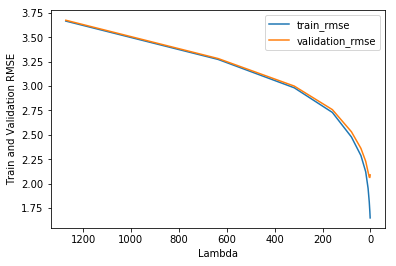

In [176]:
#GRAPH OF VALIDATION AND TRAIN RMSE VS LAMBDA
plt.plot(lambdavalues, trainRMSE, label="train_rmse")
plt.plot(lambdavalues, validationRMSE, label="validation_rmse")
plt.legend()

axis = plt.gca()
axis.set_xlim(axis.get_xlim()[::-1])
plt.ylabel('Train and Validation RMSE')
plt.xlabel('Lambda')
plt.show()

### Graph of Number of Non Zeros vs Iterations

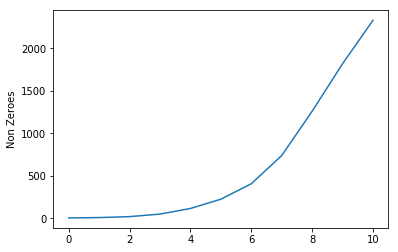

In [180]:
plt.plot(nonzeroes)
plt.ylabel('Non Zeroes')
plt.show()

In [178]:
print "Best Lambda Value: ",lambdavalues[-2]

Best Lambda Value:  2.4841204121093856


### Graph of Lambda Values vs Loss

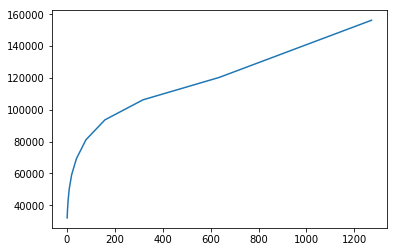

In [179]:
plt.plot(lambdavalues, lossvalues)
plt.show()

In [32]:
#Q.4.4.2
lambda_max2 = lambdavalues[-2]
trainRMSE2, lossvalues2, nonzeroes, W2, b2 = fit(lambda_max2, Y, X, W_f, b_f)

Loss:  36180.08965106129
Loss:  36035.66000815263
Loss:  35935.029868502024
Loss:  35843.55465217138
Loss:  35755.237132112394
Loss:  35668.62824138742
Loss:  35582.73359277983
Loss:  35496.832847874364
Loss:  35410.38589410598
Loss:  35322.90304492382
Loss:  35234.37702330213
Loss:  35145.01721235345
Loss:  35054.97475308699
Loss:  34964.86083228764
Loss:  34875.157004534616
Loss:  34786.64755284373
Loss:  34699.92157498068
Loss:  34615.55313928444
Loss:  34534.07360363843
Loss:  34456.07978757867
Loss:  34381.860903507586
Loss:  34311.474308122706
Loss:  34244.8148877974
Loss:  34182.012723224274
Loss:  34123.10325377961
Loss:  34068.97401716191
Loss:  34018.58520783641
Loss:  33971.59404746341
Loss:  33927.64693909805
Loss:  33886.596368243656
Loss:  33848.12517361261
Loss:  33811.96847269156
Loss:  33777.90685914278
Loss:  33745.73863016148
Loss:  33715.294977522775
Loss:  33686.42387991795
Loss:  33659.015781082955
Loss:  33632.97101368428
Loss:  33608.20845235187
Loss:  33584.651

### Getting the predicted features

In [93]:
#Q.4.2.2
m = W2.argsort()
indicesHW = m[-10:]
indicesLW = m[:10]

featureTypes = pd.read_csv('data/featureTypes.txt', header=None)

featureNamesHW = []
featureNamesLW = []

for i in range(len(indicesHW)):
    featureNamesHW.append(featureTypes[0][indicesHW[i]])
for i in range(len(indicesLW)):
    featureNamesLW.append(featureTypes[0][indicesLW[i]])
    
print "Features with highest weight: ",featureNamesHW
print "Features with lowest weight: ",featureNamesLW
# featureTypes.index

Features with highest weight:  ['acidity provides', 'truly', 'nearly', 'sweet black', 'lemony', 'ageability', 'lifesaver', 'big', 'stars', 'spearmint']
Features with lowest weight:  ['earns', 'high', 'cherry berry', 'soft', 'sparkler', 'liqueur', 'cuts', 'semillon', 'brightened', 'banana']


In [181]:
#For kaggle
validationData1 = pd.read_csv("data/valData.txt", delimiter = " ", names = ["iid","fid","fv"])
validationData1['iid'] = validationData1['iid']-1
validationData1['fid'] = validationData1['fid']-1
VX = sparse.csr_matrix((validationData1['fv'], (validationData1['iid'],validationData1['fid']))) 
VX = VX.T
YVload = pd.read_csv('data/valLabels.txt', delimiter = " ", header = None)
YV = np.array(YVload).reshape(n)

# lambda_max2 = lambdavalues[-2]
lambda_max2 = 2.848456372
trainRMSEKaggle, lossvaluesKaggle, nonzeroesKaggle, WKaggle, bKaggle = fit(lambda_max2, Y, X, W_f, b_f)

Loss:  37308.63689650287
Loss:  37136.639874213855
Loss:  37030.861807953515
Loss:  36935.845362483175
Loss:  36844.78085009905
Loss:  36755.39461285396
Loss:  36666.47504381825
Loss:  36577.3462034846
Loss:  36487.30180804904
Loss:  36396.1080161377
Loss:  36304.01133563699
Loss:  36211.07665529065
Loss:  36117.76165346349
Loss:  36024.71039077155
Loss:  35932.60941114828
Loss:  35842.15435318969
Loss:  35754.03661873106
Loss:  35668.90811905918
Loss:  35587.36518014037
Loss:  35509.746126336206
Loss:  35436.20277312189
Loss:  35366.96531223452
Loss:  35302.05682180133
Loss:  35242.51748324113
Loss:  35187.14187705397
Loss:  35135.58413803982
Loss:  35087.58161515024
Loss:  35043.18223339885
Loss:  35001.97253702596
Loss:  34963.6075524218
Loss:  34927.701105271655
Loss:  34893.95926838493
Loss:  34862.15274770031
Loss:  34832.09549256854
Loss:  34803.637749780115
Loss:  34776.66071824625
Loss:  34751.06944886556
Loss:  34726.7991764514
Loss:  34703.79316940321
Loss:  34681.9654002766

In [185]:
# print trainRMSEKaggle
testData1 = pd.read_csv('data/testData.txt', delimiter = " ", names = ["iid","fid","fv"])
testData1['iid']=testData1['iid']-1
testData1['fid']=testData1['fid']-1
X_test = sparse.csr_matrix((testData1['fv'], (testData1['iid'],testData1['fid'])))
X_test = X_test.T

In [186]:
prediction = predict(WKaggle, X_test, bKaggle)
preddf = pd.DataFrame(prediction)
preddf.index += 1

In [187]:
preddf.to_csv("predTestLabels.csv", header="")